# Validation against manual counts

In [57]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import json
import pandas as pd
import PIL
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import scipy.stats as ss
import random

# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models

# Import wildcat mods
from unet_wildcat import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2
CUDA status:  True
CUDA memory max alloc:        0 MB


Set the values below to point to the experiment used to train the WildCat model

In [118]:
# Directory for WildCat CNN training
exp_dir = "/home/pyushkevich/data/dirwin/tau/organize/exp01_tangles"

# Directory containing samples used for count-based validation. This should be generated by running the clone_samples.sh script 
# on the validation task with the -X flag (full-size patches)
cnt_dir = "/home/pyushkevich/data/dirwin/tau/tcount"

In [120]:
# Read the tangle counts dataframe. This should be generated by running the clone_samples.sh script 
# on the validation task with the -P flag (no downloading patches)
df=pd.read_csv(os.path.join(cnt_dir, 'manifest.csv'))
df.head()

,59905,2000-151-37F_ANG_AT8_1K_03-13-19_RL,candidate_roi,3572.09317175,6819.13615015,2047.0,2047.0.1,1603289813.38,pyushkevich,1609298061.72,dirwin,2000-151,ANG-37F
0,59906,2000-151-37F_ANG_AT8_1K_03-13-19_RL,candidate_roi,4588.716654,6832.922019,2047.0,2047.0,1.603290e+09,pyushkevich,1.603290e+09,pyushkevich,2000-151,ANG-37F
1,59907,2000-151-37F_ANG_AT8_1K_03-13-19_RL,rated_roi_1_mild,6801.268017,3754.311371,2047.0,2047.0,1.603290e+09,pyushkevich,1.609298e+09,dirwin,2000-151,ANG-37F
2,59908,2000-151-37F_ANG_AT8_1K_03-13-19_RL,candidate_roi,2938.269081,4596.950701,2047.0,2047.0,1.603290e+09,pyushkevich,1.603904e+09,cpeterson,2000-151,ANG-37F
3,59909,2000-151-37F_ANG_AT8_1K_03-13-19_RL,candidate_roi,4699.312594,4309.469782,2047.0,2047.0,1.603290e+09,pyushkevich,1.603290e+09,pyushkevich,2000-151,ANG-37F
4,59910,2000-151-37F_ANG_AT8_1K_03-13-19_RL,rated_roi_1_mild,3980.253106,3399.552640,2047.0,2047.0,1.603290e+09,pyushkevich,1.609298e+09,dirwin,2000-151,ANG-37F


At this point, we might want to drop all specimens from the evaluation set that were
included in the training of the model

In [72]:
exclude_df = pd.concat(
    [pd.read_csv(os.path.join(exp_dir, 'samples_train.csv'), header=0, 
                names=('id','label_name','class','specimen_name')),
     pd.read_csv(os.path.join(exp_dir, 'samples_val.csv'), header=0, 
                names=('id','label_name','class','specimen_name'))])
exclude_specimens = exclude_df['specimen_name'].unique()
exclude_specimens

array(['2000-151', '2013-223', '2005-025', '1995-057', '2009-073',
       '2004-267', '2004-055', '2017-091', '1998-077', '2008-251',
       '2005-295', '2006-027', '2000-216', '2000-085', '1999-103'],
      dtype=object)

In [107]:
df_pristine = df[~df['specimen_name'].isin(exclude_specimens)].copy()
print('Excluded %d rows' % (df.shape[0] - df_pristine.shape[0],))

Excluded 778 rows


List unique label names in the dataframe (to assist with the following command)

In [108]:
df_pristine[['id','label_name']].groupby(['label_name',]).agg('count').sort_values('label_name')

,id
label_name,
GM_Ballooned Neuron,35
GM_Pick body,1748
GM_WM rammified astrocyte,397
GM_WM_astrocytic plaques,490
GM_WM_coiled bodies,6345
GM_WM_fuzzy granular astrocyte,74
GM_WM_tufted astrocytes,159
GM_grains,570
GM_pretangle,636


Define the list of classes that constitute larger ROIs (i.e., areas in which we are counting objects) and a list of classes that constitute the objects to be counted

In [109]:
container_labels = [
    'rated_roi_0_none', 'rated_roi_01_rare', 'rated_roi_1_mild', 
    'rated_roi_2_moderate', 'rated_roi_3_severe' ]

object_of_interest_labels = [
    'GM_pretangle', 'GM_tangle']

Compute tangle counts per ROI

In [144]:
t_df = df_pristine[df_pristine['label_name'].isin(object_of_interest_labels)]
r_df = df_pristine[df_pristine['label_name'].isin(container_labels)]
tc = []
for index, row in r_df.iterrows():
    
    # Get all tangles on this slide
    t_slide = t_df[t_df['slide_name']==row['slide_name']]
    t_rect = t_slide[['x','y','w','h']].values
    t_cx,t_cy = (t_rect[:,0]+t_rect[:,2]*0.5,t_rect[:,1]+t_rect[:,3]*0.5)    
    
    # Find the centers that are inside
    x0,y0,x1,y1 = row['x'],row['y'],row['x']+row['w'],row['y']+row['h']
    inside = np.all(np.stack((t_cx >= x0, t_cx <= x1, t_cy >= y0,t_cy <= y1)), axis=0)
    tc.append(np.sum(inside))
    
c_df = r_df[['id','slide_name','label_name','specimen_name']].copy()
c_df['n_objects']=tc
c_df.head()

,id,slide_name,label_name,specimen_name,n_objects
104,60009,2002-159-38F_ANG_AT8_1K_03-13-19_RL,rated_roi_2_moderate,2002-159,1
112,60017,2002-159-38F_ANG_AT8_1K_03-13-19_RL,rated_roi_2_moderate,2002-159,2
115,60020,2002-159-38F_ANG_AT8_1K_03-13-19_RL,rated_roi_1_mild,2002-159,1
118,60023,2002-159-38F_ANG_AT8_1K_03-13-19_RL,rated_roi_2_moderate,2002-159,3
123,60028,2002-159-40F_CING_AT8_1K_03-13-19_RL,rated_roi_1_mild,2002-159,0


Plot the number of objects per ROI

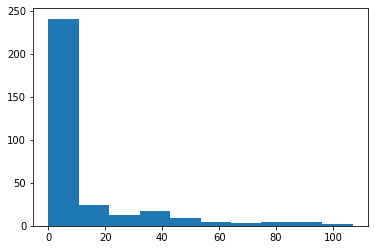

In [111]:
plt.hist(c_df['n_objects'].values);

In [112]:
# Set main directories
data_dir = os.path.join(exp_dir, "patches")
model_dir = os.path.join(exp_dir, "models")

# Load model configuration from config.json
with open(os.path.join(model_dir, 'config.json'), 'r') as jfile:
    config = json.load(jfile)

# Set global properties
num_classes=config['num_classes']
input_size=config['wildcat_upsample']['input_size']
batch_size=config['wildcat_upsample']['batch_size']

In [114]:
# Create the model
model_ft=resnet50_wildcat_upsample(
    config['num_classes'], 
    pretrained=True, 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'], 
    num_maps=config['wildcat_upsample']['num_maps'])

# Read model state
model_ft.load_state_dict(
    torch.load(os.path.join(model_dir, "wildcat_upsample.dat")))

# Send model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_ft.eval()
model_ft = model_ft.to(device)

Sending loaded model to device:  cuda:0


In [145]:
# Optionally, select to only look at a subset of the data (comment out for production)
c_df = c_df.iloc[1:20].copy()

In [146]:
# Main loop for scanning ROIs
tload=[]
tmaxcnt=[]
tpatch={}
ipatch={}
for index, row in c_df.iterrows():
    
    # Load the image
    fn='%s/all_patches/%d.png' % (cnt_dir,row['id'])
    img=PIL.Image.fromarray(np.uint8(np.asarray(PIL.Image.open(fn))[:,:,0:3]))
    ipatch[row['id']] = img
    
    # Size of the roi
    roi_dim = np.array(img.size)

    # Resample the chunk for the two networks
    tran = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    print('Sample %d   Specimen %s' % (row['id'],row['specimen_name']))

    # Convert the read chunk to tensor format
    with torch.no_grad():

        # Apply transforms and turn into correct-size torch tensor
        chunk_tensor=torch.unsqueeze(tran(img),dim=0).to(device)

        # Forward pass through the wildcat model
        x_clas = model_ft.forward_to_classifier(chunk_tensor)
        x_cpool = model_ft.spatial_pooling.class_wise(x_clas)

        # Threshold
        x_thresh = (x_cpool[0,1,:,:] - x_cpool[0,0,:,:]).cpu().detach().numpy()
        x_thresh[x_thresh < 0.0] = 0.0
        
        tpatch[row['id']]=x_thresh;
        tload.append(x_thresh.sum())   
        
        # Count - add another threshold
        zz = x_thresh
        zz[zz < 1.0] = 0.0
        
        tmaxcnt.append(len(peak_local_max(zz, min_distance=10)))
        
c_df['object_load']=tload
c_df['object_maxcnt']=tmaxcnt

Sample 60017   Specimen 2002-159
Sample 60020   Specimen 2002-159
Sample 60023   Specimen 2002-159
Sample 60028   Specimen 2002-159
Sample 60032   Specimen 2002-159
Sample 60034   Specimen 2002-159
Sample 60037   Specimen 2002-159
Sample 60044   Specimen 2002-159
Sample 60046   Specimen 2002-159
Sample 60058   Specimen 2002-159
Sample 60060   Specimen 2002-159
Sample 60064   Specimen 2002-159
Sample 60066   Specimen 2002-159
Sample 60077   Specimen 2002-159
Sample 60081   Specimen 2002-159
Sample 60091   Specimen 2002-159
Sample 60100   Specimen 2002-159
Sample 60102   Specimen 2002-159
Sample 60103   Specimen 2002-159


Spearman rho =   0.5024  p =   0.0284
Kendall  tau =   0.4241  p =   0.0199


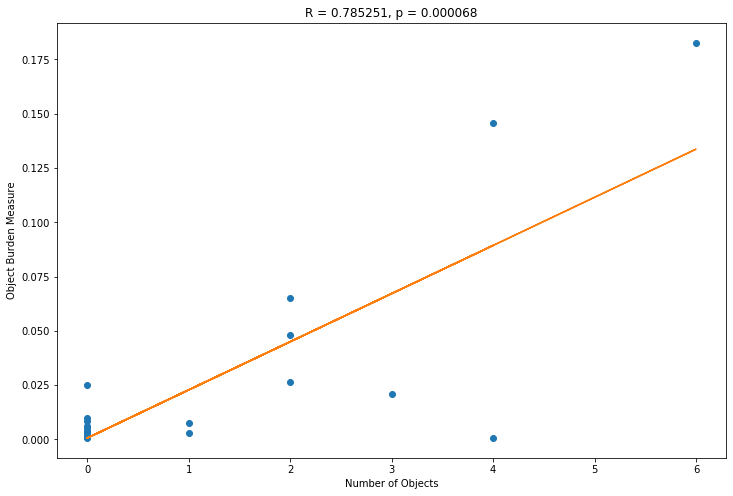

In [194]:
# Plot the stats
xi=c_df['n_objects']
y=c_df['object_load'] / 448**2

slope, intercept, r_value, p_value, std_err = ss.linregress(xi,y)
line = slope*xi+intercept
plt.figure(figsize=(12,8))
plt.plot(xi,y,'o', xi, line)
plt.title('R = %f, p = %f' % (r_value, p_value));
plt.xlabel('Number of Objects');
plt.ylabel('Object Burden Measure');

print('Spearman rho = %8.4f  p = %8.4f' % ss.spearmanr(xi,y))
print('Kendall  tau = %8.4f  p = %8.4f' % ss.kendalltau(xi,y))

Spearman rho =   0.5968  p =   0.0070
Kendall  tau =   0.5374  p =   0.0080


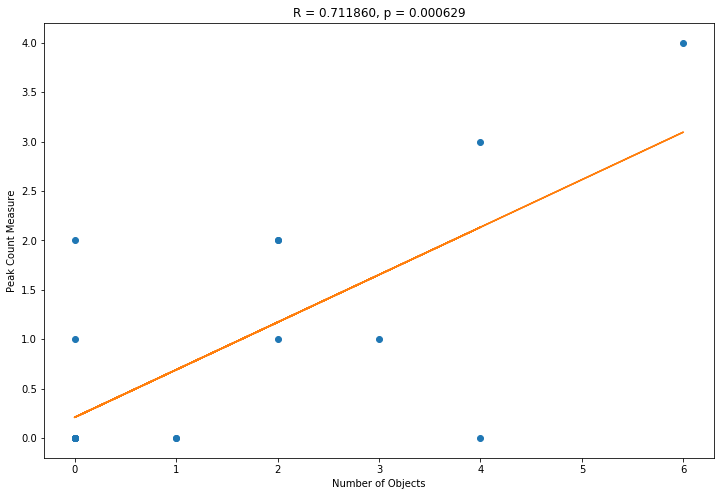

In [195]:
xi=c_df['n_objects']
y=c_df['object_maxcnt']

slope, intercept, r_value, p_value, std_err = ss.linregress(xi,y)
line = slope*xi+intercept
plt.figure(figsize=(12,8))
plt.plot(xi,y,'o', xi, line)
plt.title('R = %f, p = %f' % (r_value, p_value));
plt.xlabel('Number of Objects');
plt.ylabel('Peak Count Measure');

print('Spearman rho = %8.4f  p = %8.4f' % ss.spearmanr(xi,y))
print('Kendall  tau = %8.4f  p = %8.4f' % ss.kendalltau(xi,y))

Looking at patch 60044


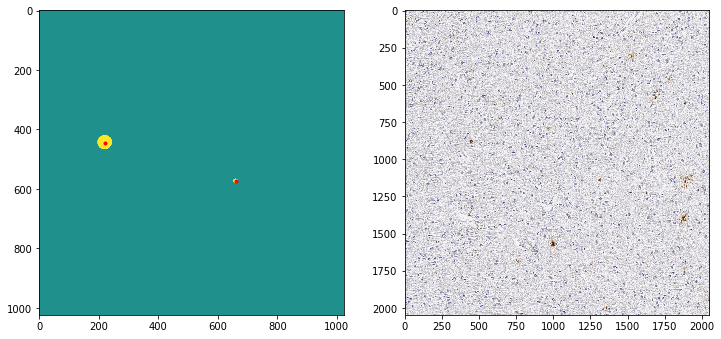

In [188]:
# Look at a random patch
k=c_df['id'].sample(1).iloc[0]
print('Looking at patch %d' % (k,))
zz=tpatch[k];
# zz[zz < 1.0] = 0.0
maxima=peak_local_max(zz, min_distance=10)

f, ax = plt.subplots(1, 2, figsize = (12, 6))
ax[0].imshow(zz,clim=(-2,2))
ax[0].plot(maxima[:, 1], maxima[:, 0], 'r.')
ax[1].imshow(ipatch[k]);

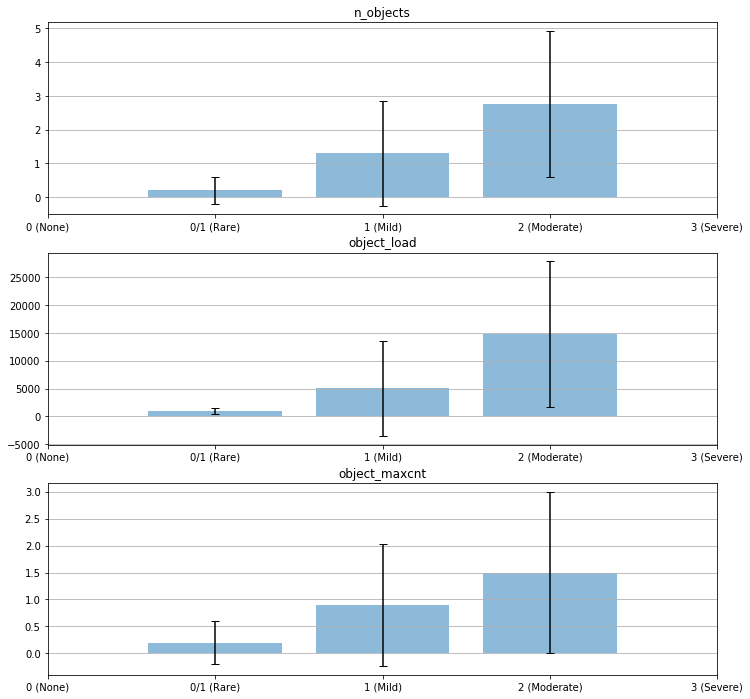

In [222]:
# Tangle counts by label
box_labels={
    'rated_roi_0_none' : '0 (None)',
    'rated_roi_01_rare' : '0/1 (Rare)',
    'rated_roi_1_mild' : '1 (Mild)',
    'rated_roi_2_moderate': '2 (Moderate)',
    'rated_roi_3_severe': '3 (Severe)'
}

def cat_plot(c_df, yvar, ax, scale=1):
    l_nt_mean = [np.mean(c_df[c_df['label_name'] == x][yvar]) for x in box_labels.keys()]
    l_nt_sd = [np.std(c_df[c_df['label_name'] == x][yvar]) for x in box_labels.keys()]
    x_pos = range(len(box_labels.keys()))
    ax.set_title(yvar)
    ax.bar(x_pos, l_nt_mean, yerr=l_nt_sd, align='center', alpha=0.5, ecolor='black', capsize=4);
    ax.set_xticks(x_pos)
    ax.set_xticklabels(box_labels.values())
    ax.yaxis.grid(True)
    return ax

f, ax = plt.subplots(3, 1, figsize = (12, 12))
cat_plot(c_df, 'n_objects', ax[0]);
cat_plot(c_df, 'object_load', ax[1]);
cat_plot(c_df, 'object_maxcnt', ax[2]);